# Wikipedia Bias Analysis: Full vs. Time-Restricted Dataset

This notebook performs retention bias analysis on Wikipedia link networks:
1. **Full Dataset Analysis**: All available data
2. **Time-Restricted Analysis**: Filtering for individuals born between 1750-1950

## Dataset
- **Edges**: `data/out/SpotlightWeightSource_MMDD_HHMM.csv` (use your most recent file)
- **Metadata**: `data/entities_filtered_by_languages.csv`

## Analysis Attributes
- **Gender bias**: Male vs Female link retention
- **Geographic bias**: Western vs Non-Western regions (based on UN subregion)
- **Temporal bias**: Historical periods (Ancient, Post-Classical, Early Modern, Mid Modern, Contemporary)

## Setup and Imports

In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging

# Add project root to Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(f"Project root: {project_root}")

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(levelname)s: %(message)s'
)

# Import analysis modules
from src import analysis, filters

print("✓ Modules imported successfully")

# Set visualization defaults
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

# Helper function for extracting dataset name
def extract_dataset_name(csv_path):
    """Extract dataset name from CSV filename (without extension)."""
    basename = os.path.basename(csv_path)
    return os.path.splitext(basename)[0]

print("✓ Helper functions loaded")

Project root: /home/vlr/Workspaces/WikipediaBiasProject/PyProject
✓ Modules imported successfully
✓ Helper functions loaded


## Configuration

In [2]:
# Data paths (update EDGE_CSV to your most recent SpotlightWeightSource_MMDD_HHMM.csv)
EDGE_CSV = os.path.join(project_root, "data/out/SpotlightWeightSource_0102_0505_fullmatch_corrected.csv")
META_CSV = os.path.join(project_root, "data/entities_filtered_by_languages.csv")
BASE_OUTPUT_DIR = os.path.join(project_root, "data/out/plots")
os.makedirs(BASE_OUTPUT_DIR, exist_ok=True)

# Extract dataset name from edge CSV
DATASET_NAME = extract_dataset_name(EDGE_CSV)

# Analysis parameters
MIN_EDGES = 500  # Minimum edges for statistical reliability
RESOLUTION = 50  # Threshold points (higher = more precise but slower)
LOGSPACE_LOWER_BOUND = -14  # Lower bound for logspace threshold calculation
SELECTED_LANGUAGES = ['en', 'de', 'fr', 'it', 'es']

# Attributes to analyze
ATTRIBUTES = ['gender', 'un_subregion', 'bigperiod_birth']

# Time restriction
MIN_YEAR = 1750
MAX_YEAR = 1950

# Build output directories using analysis.py functions
OUTPUT_DIRS_FULL = analysis.build_analysis_output_dirs(
    base_output_dir=BASE_OUTPUT_DIR,
    dataset_name=DATASET_NAME,
    filter_description="full",
    resolution=RESOLUTION,
    min_edges=MIN_EDGES,
    selected_languages=SELECTED_LANGUAGES,
    attributes=ATTRIBUTES,
    logspace_lower_bound=LOGSPACE_LOWER_BOUND
)

OUTPUT_DIRS_RESTRICTED = analysis.build_analysis_output_dirs(
    base_output_dir=BASE_OUTPUT_DIR,
    dataset_name=DATASET_NAME,
    filter_description=f"restricted_{MIN_YEAR}_{MAX_YEAR}",
    resolution=RESOLUTION,
    min_edges=MIN_EDGES,
    selected_languages=SELECTED_LANGUAGES,
    attributes=ATTRIBUTES,
    logspace_lower_bound=LOGSPACE_LOWER_BOUND
)

# Note on transformations and caching:
# The caching system tracks all parameters EXCEPT custom transformation functions.
# Default transformations are used: gender (identity), bigperiod_birth (simplified periods),
# un_subregion (Western/Non-Western). If you modify transformations while keeping other
# parameters the same, manually move previous results to a different directory to avoid
# cache conflicts.

print(f"Configuration: {len(SELECTED_LANGUAGES)} languages, {MIN_YEAR}-{MAX_YEAR}, min_edges={MIN_EDGES}")
print(f"Analyzing attributes: {', '.join(ATTRIBUTES)}")
print(f"Dataset: {DATASET_NAME}")
print(f"Output directories:")
print(f"  Full: {OUTPUT_DIRS_FULL['base']}")
print(f"  Restricted: {OUTPUT_DIRS_RESTRICTED['base']}")

Configuration: 5 languages, 1750-1950, min_edges=500
Analyzing attributes: gender, un_subregion, bigperiod_birth
Dataset: SpotlightWeightSource_0102_0505_fullmatch_corrected
Output directories:
  Full: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_fullmatch_corrected_full_res50_min500_langs5_attrs3
  Restricted: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_fullmatch_corrected_restricted_1750_1950_res50_min500_langs5_attrs3


## Load Data

In [3]:
print("Loading data...")
edges_df = pd.read_csv(EDGE_CSV)
print(f"✓ Loaded {len(edges_df):,} edges")

edges_df = edges_df[edges_df['source_wikidata_id'] != edges_df['target_wikidata_id']].copy()
print(f"✓ Filtered self-loops, remaining edges: {len(edges_df):,}")

meta_df = pd.read_csv(META_CSV)

print(f"✓ Loaded {len(meta_df):,} metadata records")
print(f"\nEdge columns: {list(edges_df.columns)}")
print(f"Meta columns: {list(meta_df.columns)}")

Loading data...
✓ Loaded 12,444,180 edges
✓ Filtered self-loops, remaining edges: 12,438,067
✓ Loaded 94,403 metadata records

Edge columns: ['language_code', 'source_wikidata_id', 'target_wikidata_id', 'weight']
Meta columns: ['wikidata_id', 'birth', 'bigperiod_birth', 'un_subregion', 'gender']


---
# Analysis 1: Full Dataset

In [4]:
print("="*80)
print("FULL DATASET ANALYSIS")
print("="*80)

# Run analysis (caching handled by analysis.py)
retention_full = analysis.run_bias_analysis(
    edges_df=edges_df,
    meta_df=meta_df,
    edge_id_map={
        'source_wikidata_id': 'src',
        'target_wikidata_id': 'trg',
        'weight': 'nij'
    },
    meta_id_col='wikidata_id',
    # Using default transformations (gender, bigperiod_birth, un_subregion)
    selected_languages=SELECTED_LANGUAGES,
    min_edges=MIN_EDGES,
    resolution=RESOLUTION,
    filter_zero_weights=True,
    language_col='language_code',
    add_aggregated_all=True,
    pre_transform_filters=None,
    post_transform_filters=None,
    dataset_label='full'
)

# Save results with full parameter information
print("\nSaving results...")
analysis.save_analysis_results(
    retention_full, 
    OUTPUT_DIRS_FULL, 
    SELECTED_LANGUAGES + ['all'], 
    ATTRIBUTES,
    resolution=RESOLUTION,
    min_edges=MIN_EDGES,
    logspace_lower_bound=LOGSPACE_LOWER_BOUND,
    dataset_name=DATASET_NAME,
    filter_description="full"
)
print("✓ Results saved")

INFO: Processing dataframes


FULL DATASET ANALYSIS


INFO: Loaded 2831950 edges with positive weight
INFO: Analyzing 6 language(s): ['en', 'de', 'fr', 'it', 'es', 'all']
INFO: Processing language: en
INFO: Processing language: de
INFO: Processing language: fr
INFO: Processing language: it
INFO: Processing language: es
INFO: Processing language: all
INFO: Analysis complete - returning raw retention results
INFO: Saved: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_fullmatch_corrected_full_res50_min500_langs5_attrs3/auc/auc_en_gender.csv
INFO: Saved: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_fullmatch_corrected_full_res50_min500_langs5_attrs3/retention_data/retention_curves_en_gender.csv
INFO: Saved: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_fullmatch_corrected_full_res50_min500_langs5_attrs3/retention_data/node_retention_en_gender.csv
INFO: Saved: /home/vlr/Workspaces/Wikipe


Saving results...
✓ Results saved


### Display Full Dataset Results

In [5]:
print("\n" + "="*80)
print("FULL DATASET RESULTS")
print("="*80)

for lang in retention_full:
    print(f"\n{'━'*80}")
    print(f" Language: {lang.upper()}")
    print(f"{'━'*80}")
    
    for attr in retention_full[lang]:
        result_tuple = retention_full[lang][attr]
        if len(result_tuple) == 4:
            edge_results, node_results, auc_matrix, dataset_label = result_tuple
        else:
            edge_results, node_results, auc_matrix = result_tuple
        
        print(f"\n  {attr.upper()} - AUC Matrix:")
        print(f"  {'-'*76}")
        print(auc_matrix.to_string(index=True))
        
        print(f"\n  {attr.upper()} - Edge Pairs Summary:")
        print(f"  {'-'*76}")
        for res in edge_results:
            src, trg = res['pair']
            print(f"    {src:15} → {trg:15}  |  AUC: {res['auc']:.4f}  |  Edges: {res['n_edges']:,}")
        
        if not edge_results:
            print(f"    (No pairs met the minimum threshold of {MIN_EDGES} edges)")


FULL DATASET RESULTS

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
 Language: EN
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  GENDER - AUC Matrix:
  ----------------------------------------------------------------------------
          Female      Male  Other
Female  0.999951  0.999867    NaN
Male    0.999939  0.999884    NaN
Other        NaN       NaN    NaN

  GENDER - Edge Pairs Summary:
  ----------------------------------------------------------------------------
    Female          → Female           |  AUC: 1.0000  |  Edges: 69,172
    Female          → Male             |  AUC: 0.9999  |  Edges: 88,971
    Male            → Female           |  AUC: 0.9999  |  Edges: 59,015
    Male            → Male             |  AUC: 0.9999  |  Edges: 556,161

  BIGPERIOD_BIRTH - AUC Matrix:
  ----------------------------------------------------------------------------
                 Ancient  Contemporary  Early Mode

### Save Full Dataset Results

In [6]:
# Results are automatically saved with parameter-inclusive directory names
print(f"Full dataset results are in: {OUTPUT_DIRS_FULL['base']}")
print(f"  - Directory includes: resolution={RESOLUTION}, min_edges={MIN_EDGES}, languages={len(SELECTED_LANGUAGES)}")
print(f"  - AUC matrices: {OUTPUT_DIRS_FULL['auc']}")
print(f"  - Retention curves data: {OUTPUT_DIRS_FULL['retention_data']}")
print(f"  - Cache metadata: {os.path.join(OUTPUT_DIRS_FULL['base'], 'cache_metadata.json')}")

Full dataset results are in: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_fullmatch_corrected_full_res50_min500_langs5_attrs3
  - Directory includes: resolution=50, min_edges=500, languages=5
  - AUC matrices: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_fullmatch_corrected_full_res50_min500_langs5_attrs3/auc
  - Retention curves data: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_fullmatch_corrected_full_res50_min500_langs5_attrs3/retention_data
  - Cache metadata: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_fullmatch_corrected_full_res50_min500_langs5_attrs3/cache_metadata.json


---
# Analysis 2: Time-Restricted Dataset (1750-1950)

In [7]:
print("="*80)
print(f"TIME-RESTRICTED DATASET ANALYSIS ({MIN_YEAR}-{MAX_YEAR})")
print("="*80)

# Run analysis with time restriction (caching handled by analysis.py)
year_filter = filters.restrict_years(MIN_YEAR, MAX_YEAR)

retention_restricted = analysis.run_bias_analysis(
    edges_df=edges_df,
    meta_df=meta_df,
    edge_id_map={
        'source_wikidata_id': 'src',
        'target_wikidata_id': 'trg',
        'weight': 'nij'
    },
    meta_id_col='wikidata_id',
    # Using default transformations (gender, bigperiod_birth, un_subregion)
    selected_languages=SELECTED_LANGUAGES,
    min_edges=MIN_EDGES,
    resolution=RESOLUTION,
    filter_zero_weights=True,
    language_col='language_code',
    add_aggregated_all=True,
    pre_transform_filters=[year_filter],
    post_transform_filters=None,
    dataset_label=f'restricted_{MIN_YEAR}_{MAX_YEAR}'
)

# Save results with full parameter information
print("\nSaving results...")
analysis.save_analysis_results(
    retention_restricted, 
    OUTPUT_DIRS_RESTRICTED, 
    SELECTED_LANGUAGES + ['all'], 
    ATTRIBUTES,
    resolution=RESOLUTION,
    min_edges=MIN_EDGES,
    logspace_lower_bound=LOGSPACE_LOWER_BOUND,
    dataset_name=DATASET_NAME,
    filter_description=f'restricted_{MIN_YEAR}_{MAX_YEAR}'
)
print("✓ Results saved")

INFO: Processing dataframes


TIME-RESTRICTED DATASET ANALYSIS (1750-1950)


INFO: Loaded 2831950 edges with positive weight
INFO: Analyzing 6 language(s): ['en', 'de', 'fr', 'it', 'es', 'all']
INFO: Processing language: en
INFO: After pre-transform filters for en: 283604 edges remaining
INFO: Processing language: de
INFO: After pre-transform filters for de: 168261 edges remaining
INFO: Processing language: fr
INFO: After pre-transform filters for fr: 235420 edges remaining
INFO: Processing language: it
INFO: After pre-transform filters for it: 204216 edges remaining
INFO: Processing language: es
INFO: After pre-transform filters for es: 185435 edges remaining
INFO: Processing language: all
INFO: After pre-transform filters for all: 611641 edges remaining
INFO: Analysis complete - returning raw retention results
INFO: Saved: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_fullmatch_corrected_restricted_1750_1950_res50_min500_langs5_attrs3/auc/auc_en_gender.csv
INFO: Saved: /home/vlr/Workspaces/WikipediaBiasProj


Saving results...
✓ Results saved


### Display Time-Restricted Results

In [8]:
print("\n" + "="*80)
print(f"TIME-RESTRICTED ({MIN_YEAR}-{MAX_YEAR}) RESULTS")
print("="*80)

for lang in retention_restricted:
    print(f"\n{'━'*80}")
    print(f" Language: {lang.upper()}")
    print(f"{'━'*80}")
    
    for attr in retention_restricted[lang]:
        # Handle both 3-tuple (old format) and 4-tuple (new format with dataset_label)
        result_tuple = retention_restricted[lang][attr]
        if len(result_tuple) == 4:
            edge_results, node_results, auc_matrix, dataset_label = result_tuple
        else:
            edge_results, node_results, auc_matrix = result_tuple
        
        print(f"\n  {attr.upper()} - AUC Matrix:")
        print(f"  {'-'*76}")
        print(auc_matrix.to_string(index=True))
        
        print(f"\n  {attr.upper()} - Edge Pairs Summary:")
        print(f"  {'-'*76}")
        for res in edge_results:
            src, trg = res['pair']
            print(f"    {src:15} → {trg:15}  |  AUC: {res['auc']:.4f}  |  Edges: {res['n_edges']:,}")
        
        if not edge_results:
            print(f"    (No pairs met the minimum threshold of {MIN_EDGES} edges)")


TIME-RESTRICTED (1750-1950) RESULTS

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
 Language: EN
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  GENDER - AUC Matrix:
  ----------------------------------------------------------------------------
          Female      Male  Other
Female  0.999964  0.999877    NaN
Male    0.999912  0.999866    NaN
Other        NaN       NaN    NaN

  GENDER - Edge Pairs Summary:
  ----------------------------------------------------------------------------
    Female          → Female           |  AUC: 1.0000  |  Edges: 13,721
    Female          → Male             |  AUC: 0.9999  |  Edges: 33,930
    Male            → Female           |  AUC: 0.9999  |  Edges: 24,108
    Male            → Male             |  AUC: 0.9999  |  Edges: 211,644

  BIGPERIOD_BIRTH - AUC Matrix:
  ----------------------------------------------------------------------------
              Contemporary  Early M

### Save Time-Restricted Results

In [9]:
# Results are automatically saved with parameter-inclusive directory names
print(f"Restricted dataset results are in: {OUTPUT_DIRS_RESTRICTED['base']}")
print(f"  - Directory includes: resolution={RESOLUTION}, min_edges={MIN_EDGES}, languages={len(SELECTED_LANGUAGES)}")
print(f"  - AUC matrices: {OUTPUT_DIRS_RESTRICTED['auc']}")
print(f"  - Retention curves data: {OUTPUT_DIRS_RESTRICTED['retention_data']}")
print(f"  - Cache metadata: {os.path.join(OUTPUT_DIRS_RESTRICTED['base'], 'cache_metadata.json')}")

Restricted dataset results are in: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_fullmatch_corrected_restricted_1750_1950_res50_min500_langs5_attrs3
  - Directory includes: resolution=50, min_edges=500, languages=5
  - AUC matrices: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_fullmatch_corrected_restricted_1750_1950_res50_min500_langs5_attrs3/auc
  - Retention curves data: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_fullmatch_corrected_restricted_1750_1950_res50_min500_langs5_attrs3/retention_data
  - Cache metadata: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_fullmatch_corrected_restricted_1750_1950_res50_min500_langs5_attrs3/cache_metadata.json


---
# Visualization: Retention Curves Comparison

FULL DATASET VISUALIZATIONS
Creating and saving plots...


INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_fullmatch_corrected_full_res50_min500_langs5_attrs3/retention_curves_full/retention_curves_en_gender.png


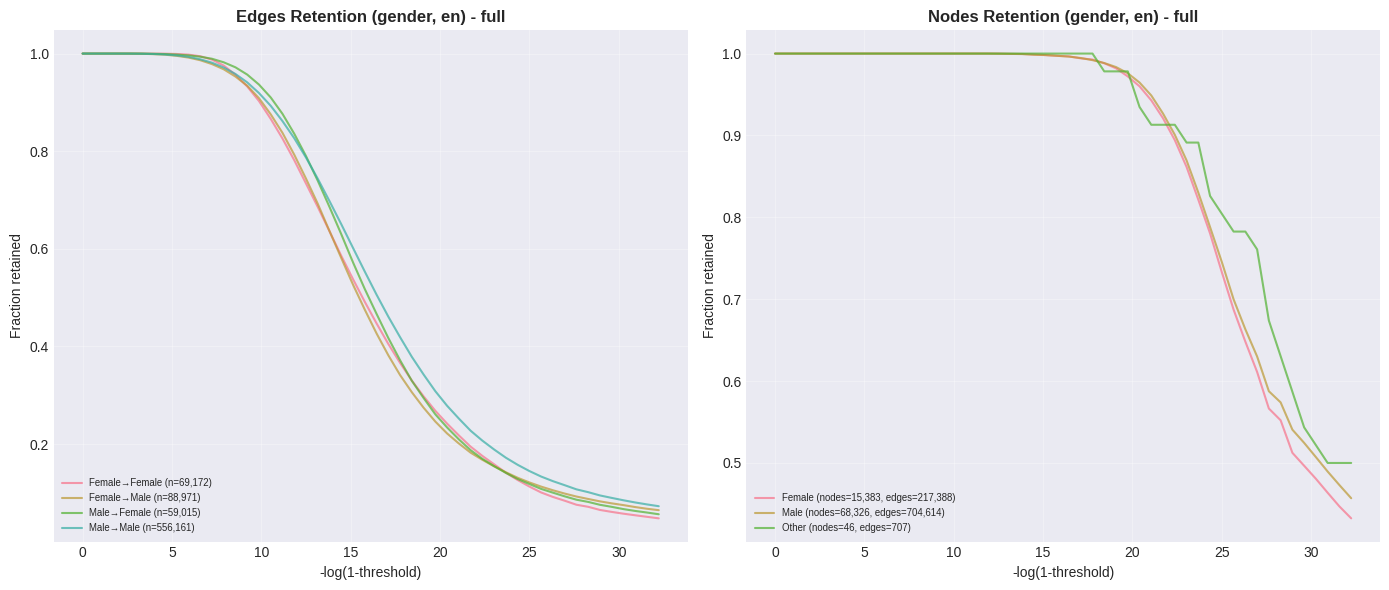

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_fullmatch_corrected_full_res50_min500_langs5_attrs3/heatmaps_full/heatmap_en_gender.png


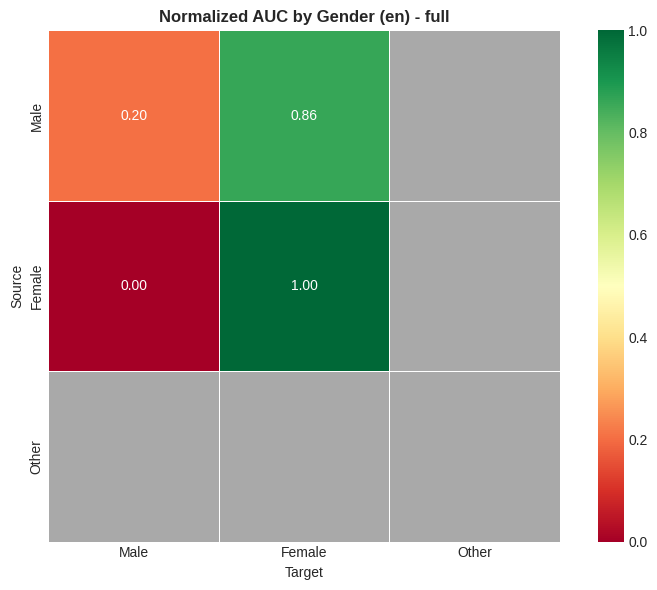

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_fullmatch_corrected_full_res50_min500_langs5_attrs3/retention_curves_full/retention_curves_en_un_subregion.png


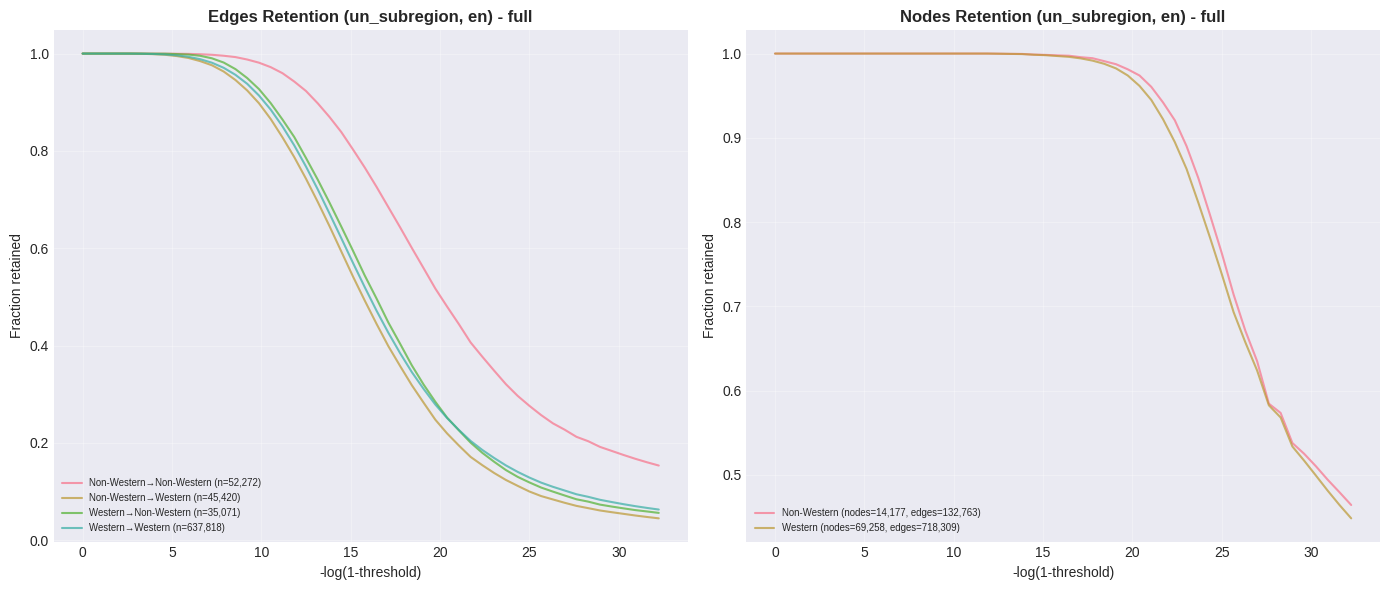

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_fullmatch_corrected_full_res50_min500_langs5_attrs3/heatmaps_full/heatmap_en_un_subregion.png


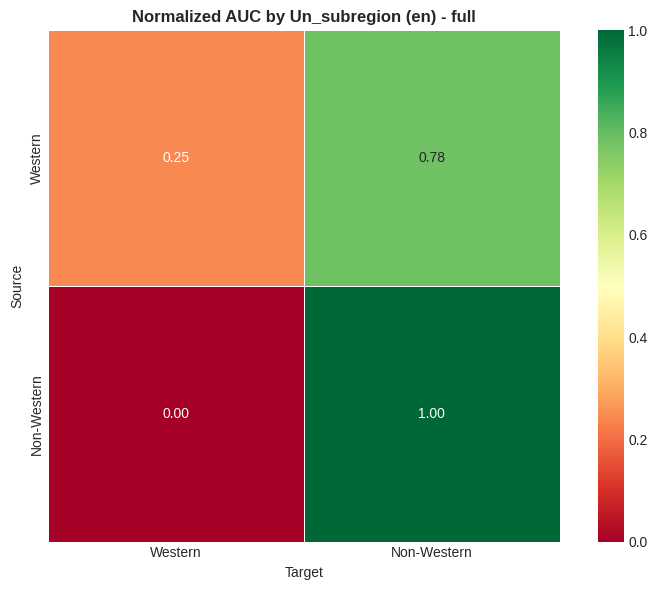

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_fullmatch_corrected_full_res50_min500_langs5_attrs3/retention_curves_full/retention_curves_en_bigperiod_birth.png


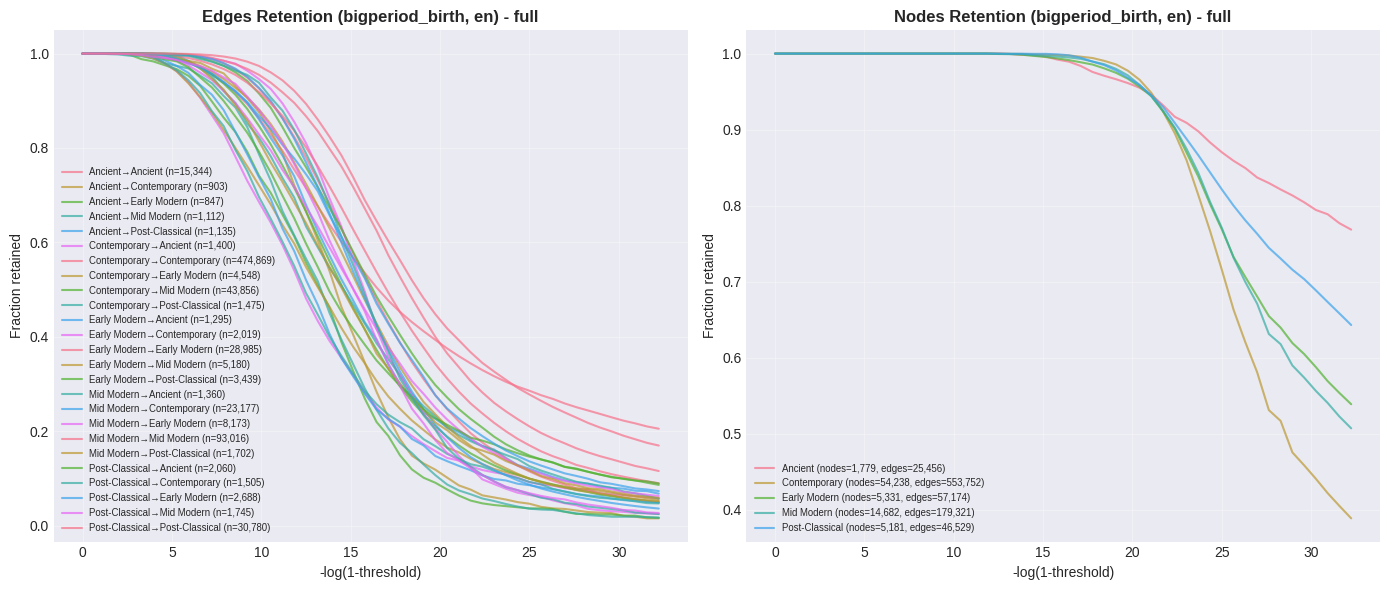

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_fullmatch_corrected_full_res50_min500_langs5_attrs3/heatmaps_full/heatmap_en_bigperiod_birth.png


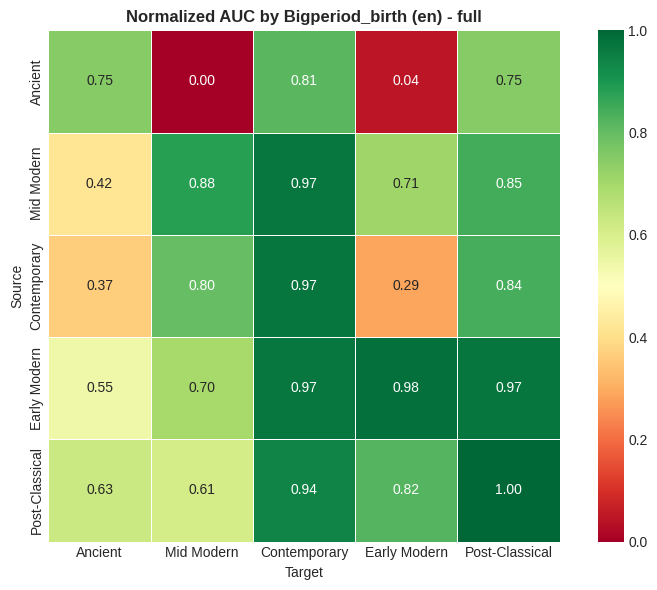

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_fullmatch_corrected_full_res50_min500_langs5_attrs3/retention_curves_full/retention_curves_all_gender.png


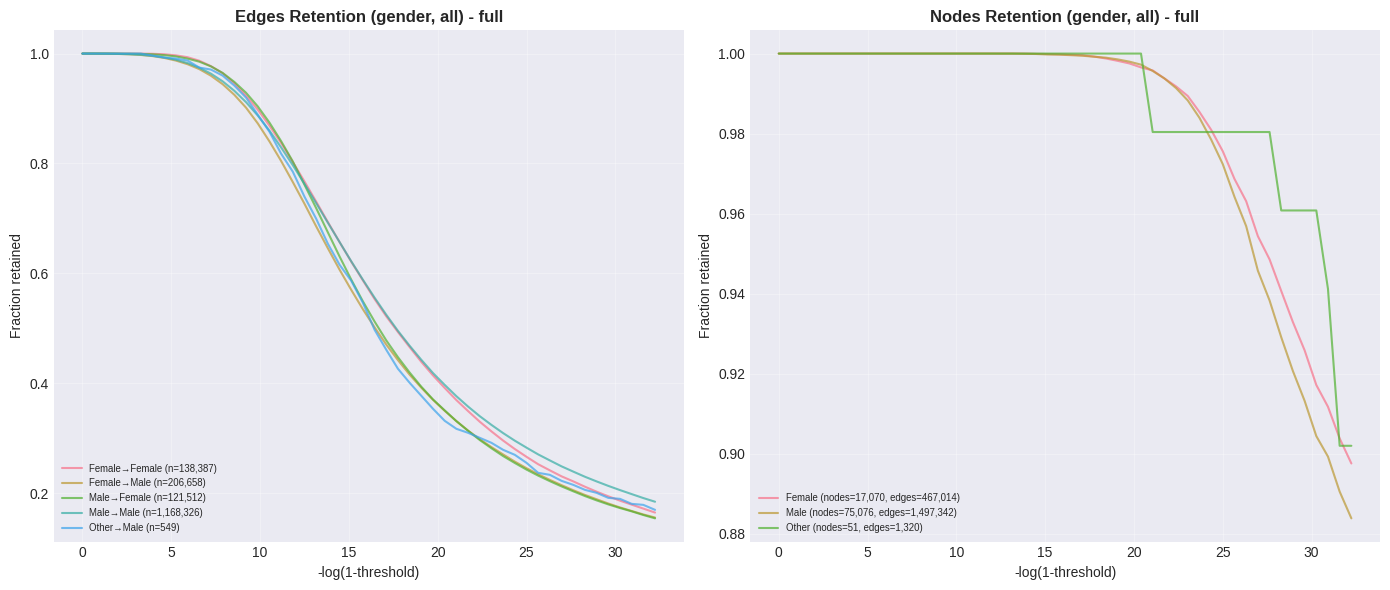

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_fullmatch_corrected_full_res50_min500_langs5_attrs3/heatmaps_full/heatmap_all_gender.png


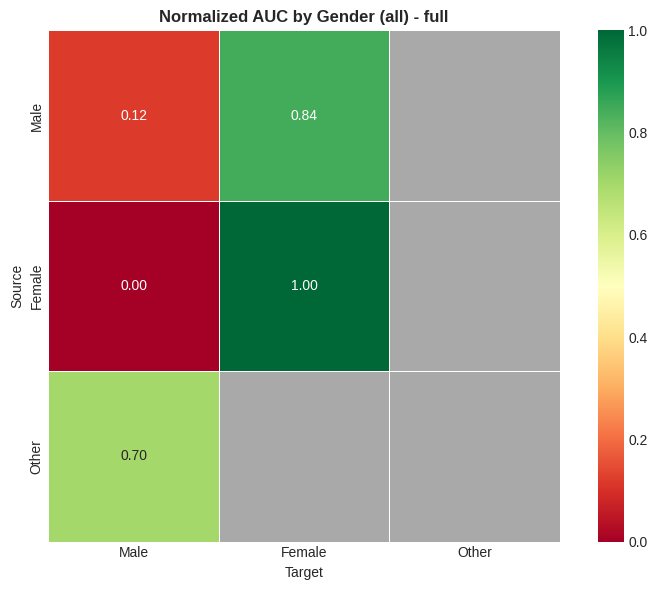

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_fullmatch_corrected_full_res50_min500_langs5_attrs3/retention_curves_full/retention_curves_all_un_subregion.png


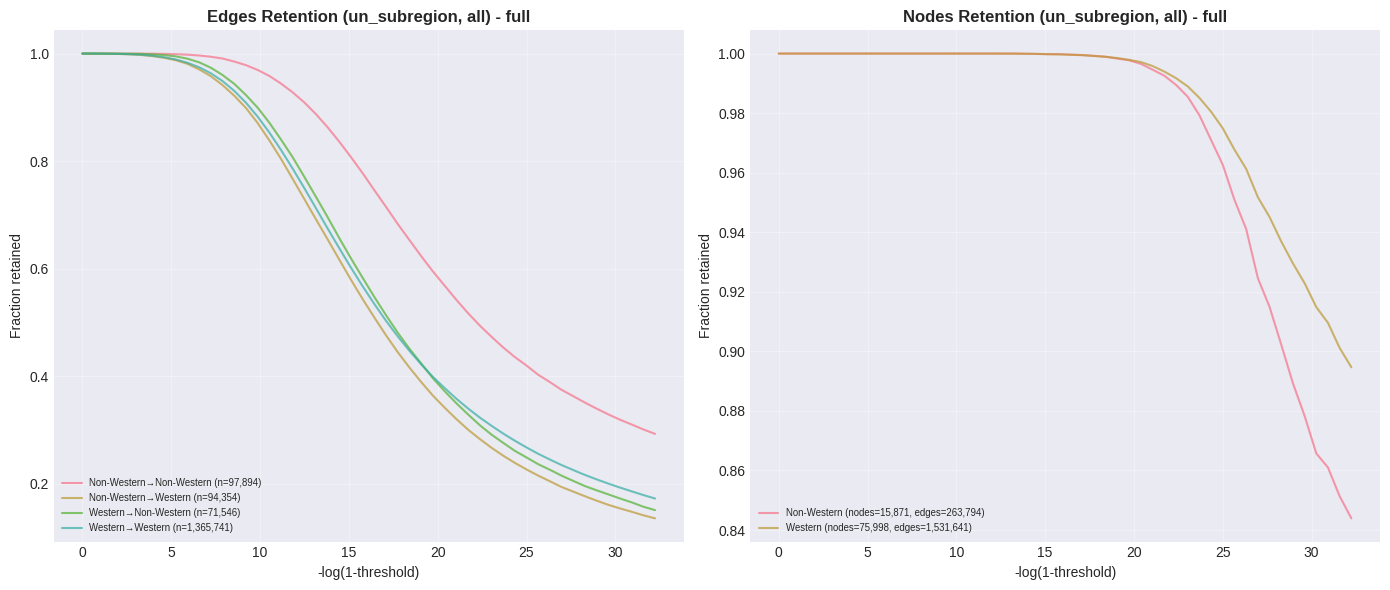

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_fullmatch_corrected_full_res50_min500_langs5_attrs3/heatmaps_full/heatmap_all_un_subregion.png


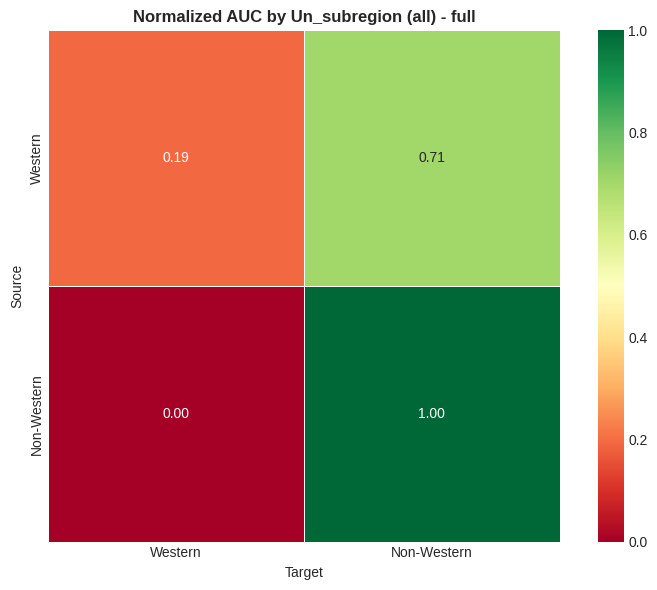

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_fullmatch_corrected_full_res50_min500_langs5_attrs3/retention_curves_full/retention_curves_all_bigperiod_birth.png


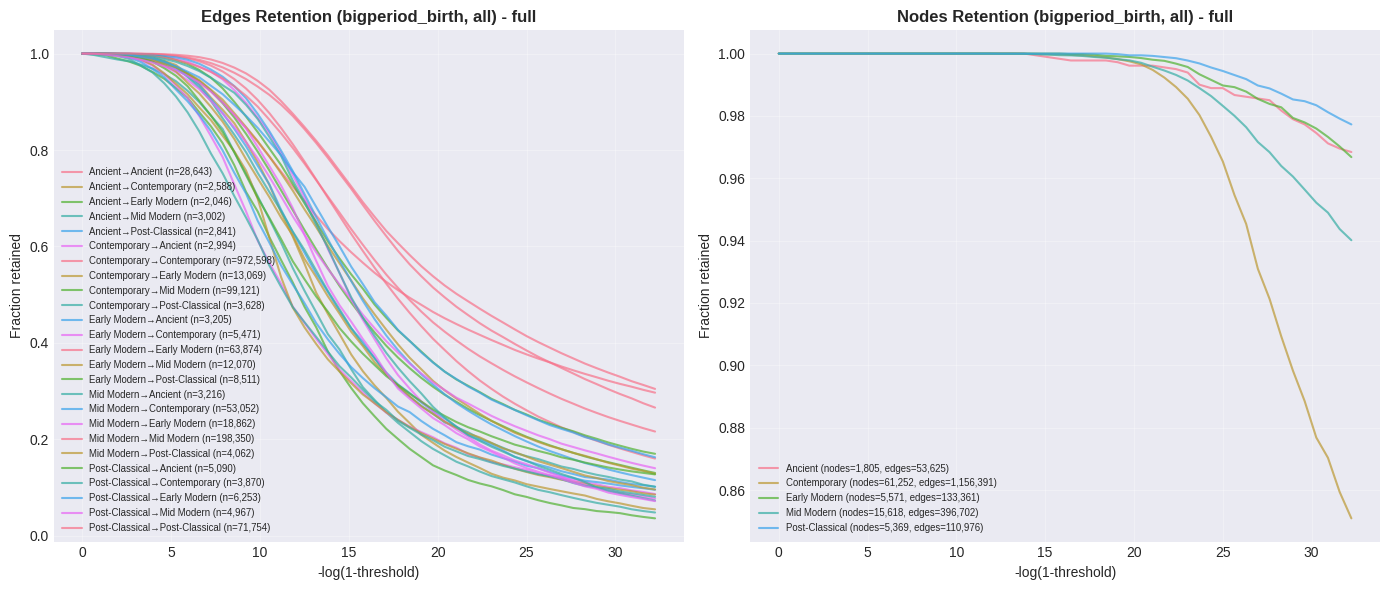

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_fullmatch_corrected_full_res50_min500_langs5_attrs3/heatmaps_full/heatmap_all_bigperiod_birth.png


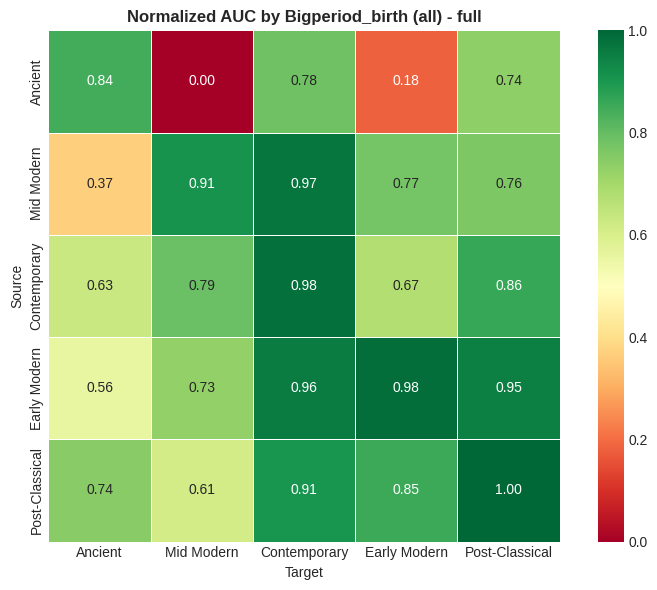


TIME-RESTRICTED (1750-1950) VISUALIZATIONS
Creating and saving plots...


INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_fullmatch_corrected_restricted_1750_1950_res50_min500_langs5_attrs3/retention_curves_restricted_1750_1950/retention_curves_en_gender.png


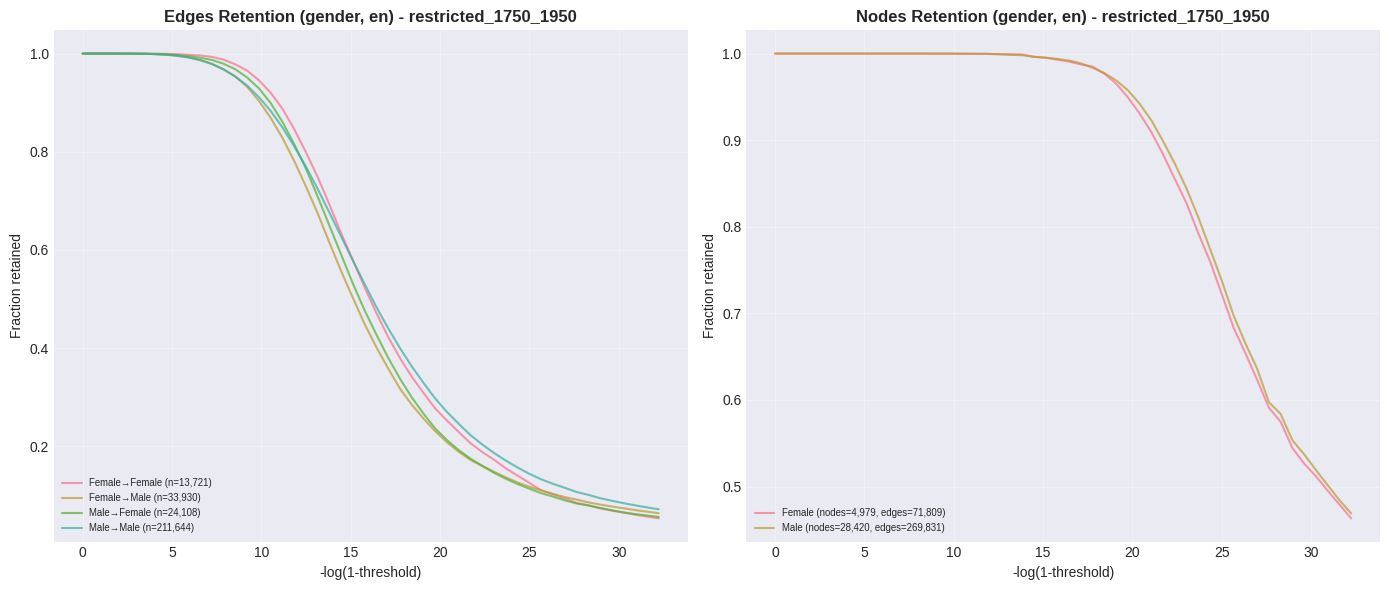

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_fullmatch_corrected_restricted_1750_1950_res50_min500_langs5_attrs3/heatmaps_restricted_1750_1950/heatmap_en_gender.png


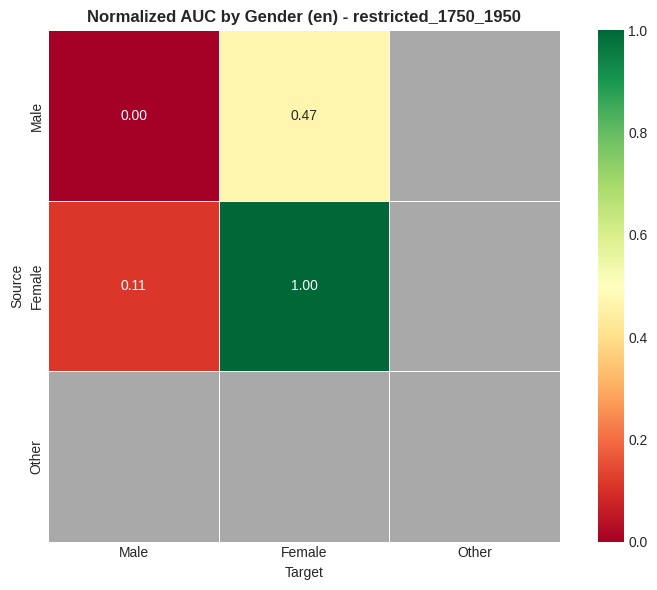

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_fullmatch_corrected_restricted_1750_1950_res50_min500_langs5_attrs3/retention_curves_restricted_1750_1950/retention_curves_en_un_subregion.png


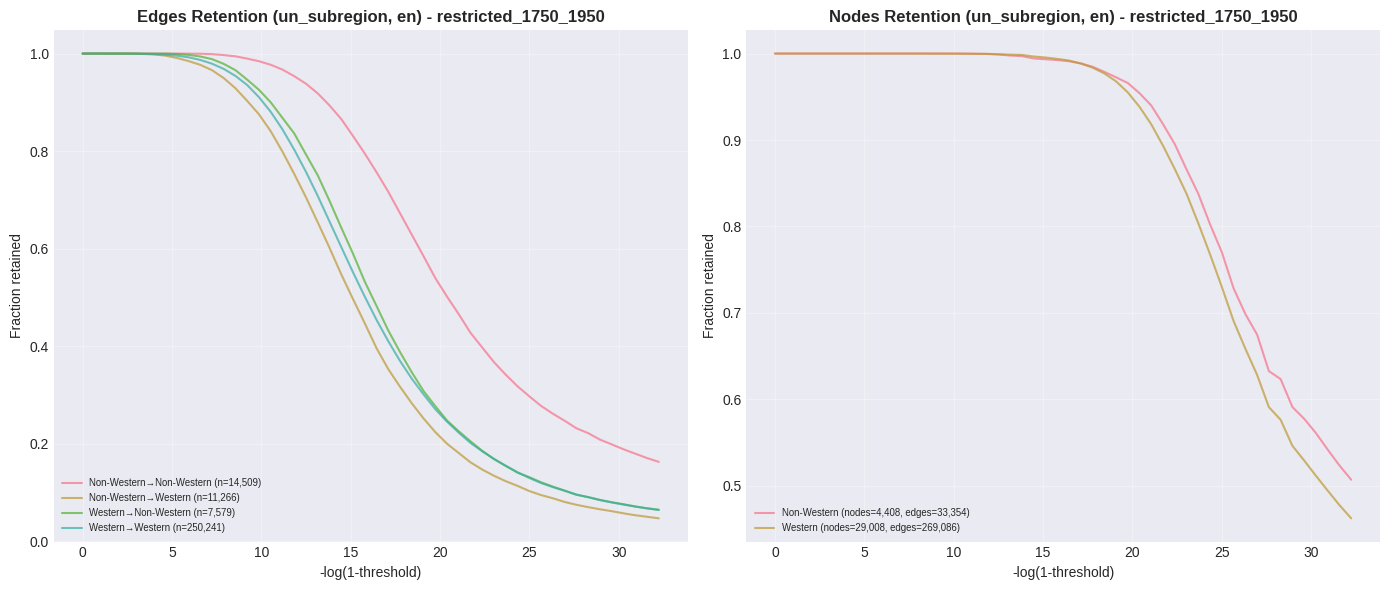

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_fullmatch_corrected_restricted_1750_1950_res50_min500_langs5_attrs3/heatmaps_restricted_1750_1950/heatmap_en_un_subregion.png


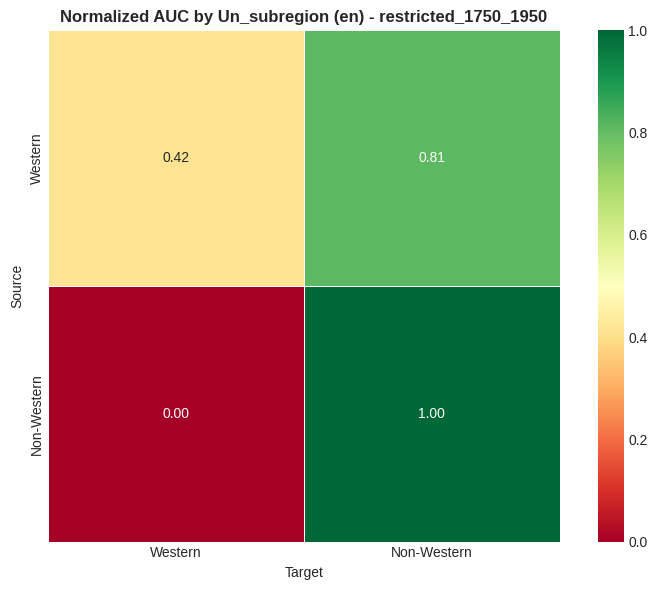

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_fullmatch_corrected_restricted_1750_1950_res50_min500_langs5_attrs3/retention_curves_restricted_1750_1950/retention_curves_en_bigperiod_birth.png


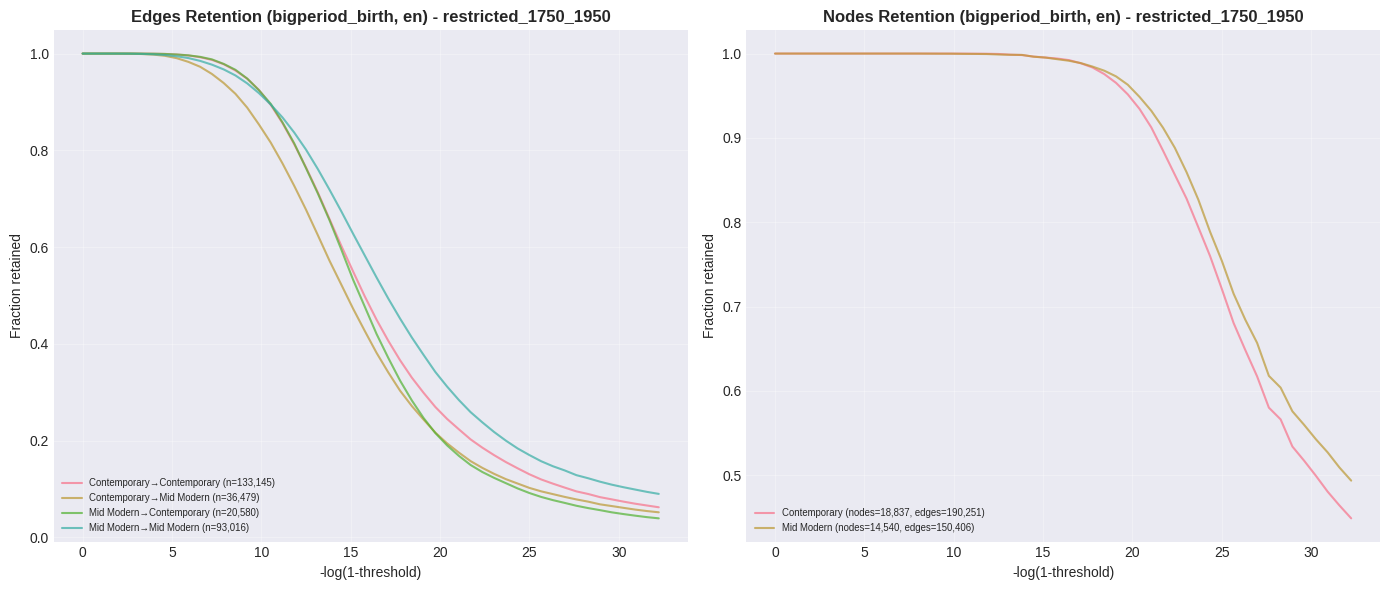

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_fullmatch_corrected_restricted_1750_1950_res50_min500_langs5_attrs3/heatmaps_restricted_1750_1950/heatmap_en_bigperiod_birth.png


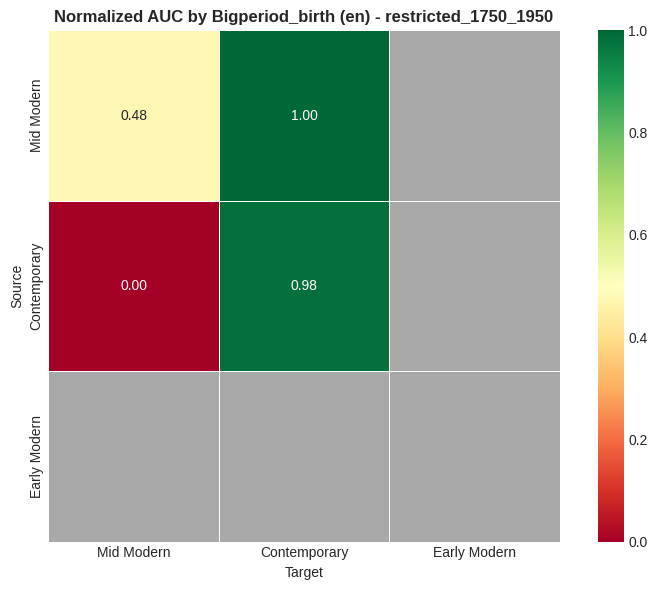

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_fullmatch_corrected_restricted_1750_1950_res50_min500_langs5_attrs3/retention_curves_restricted_1750_1950/retention_curves_all_gender.png


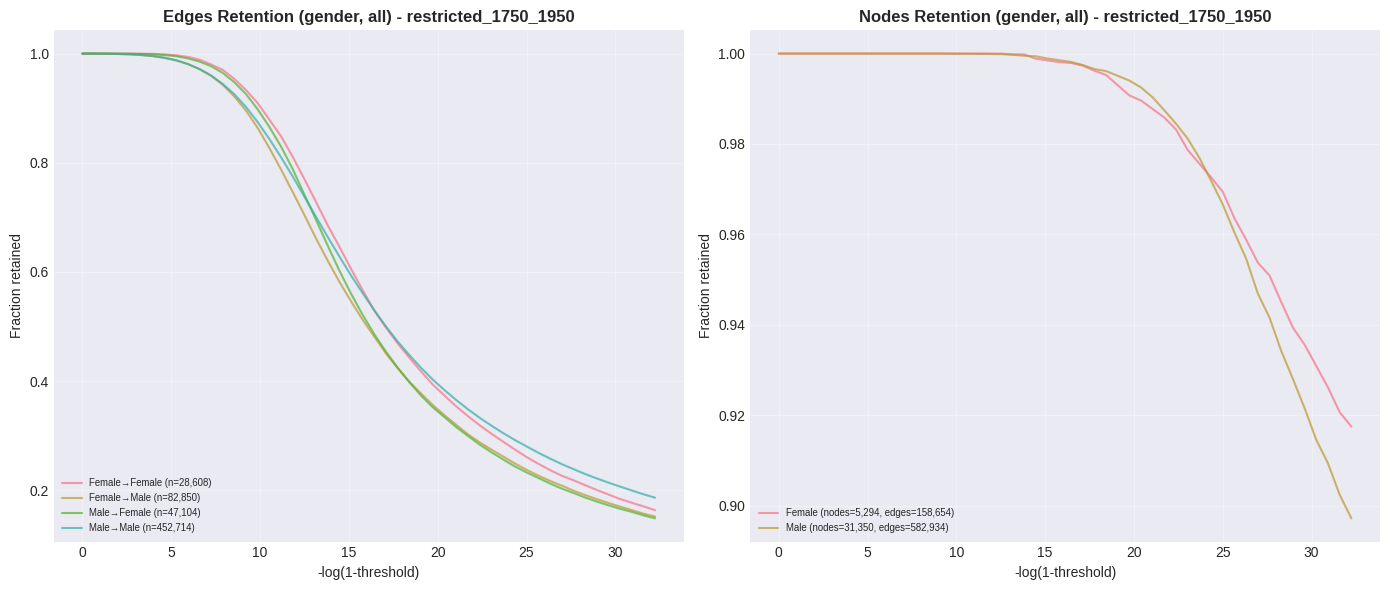

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_fullmatch_corrected_restricted_1750_1950_res50_min500_langs5_attrs3/heatmaps_restricted_1750_1950/heatmap_all_gender.png


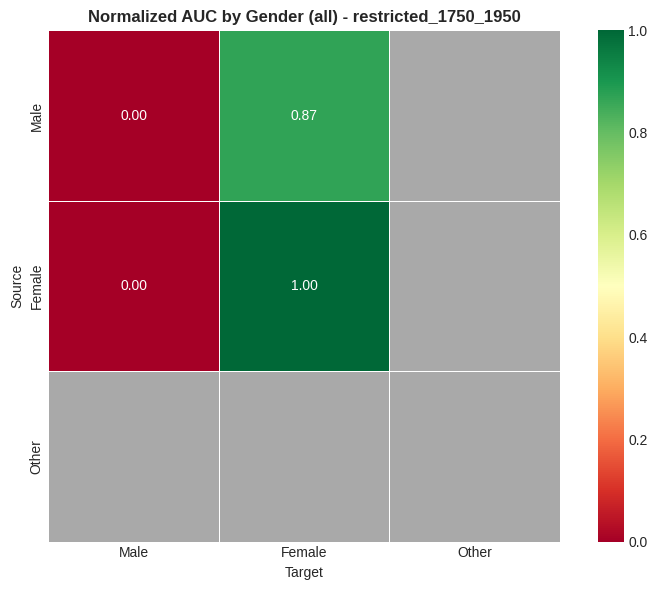

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_fullmatch_corrected_restricted_1750_1950_res50_min500_langs5_attrs3/retention_curves_restricted_1750_1950/retention_curves_all_un_subregion.png


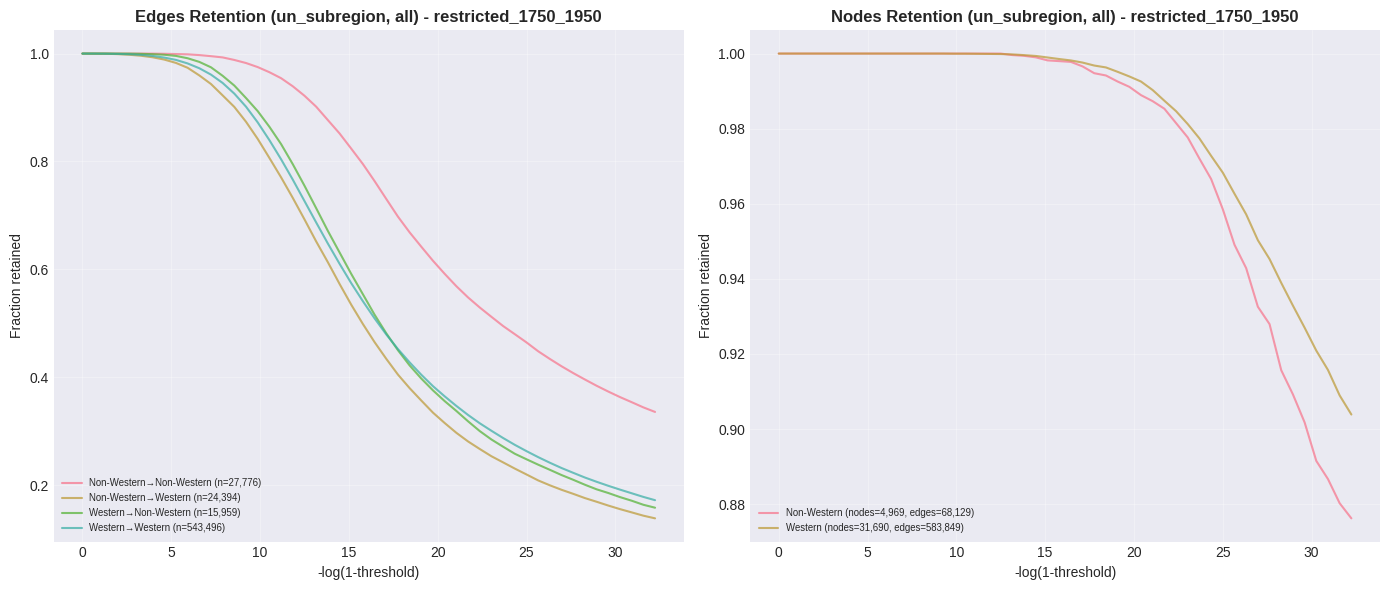

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_fullmatch_corrected_restricted_1750_1950_res50_min500_langs5_attrs3/heatmaps_restricted_1750_1950/heatmap_all_un_subregion.png


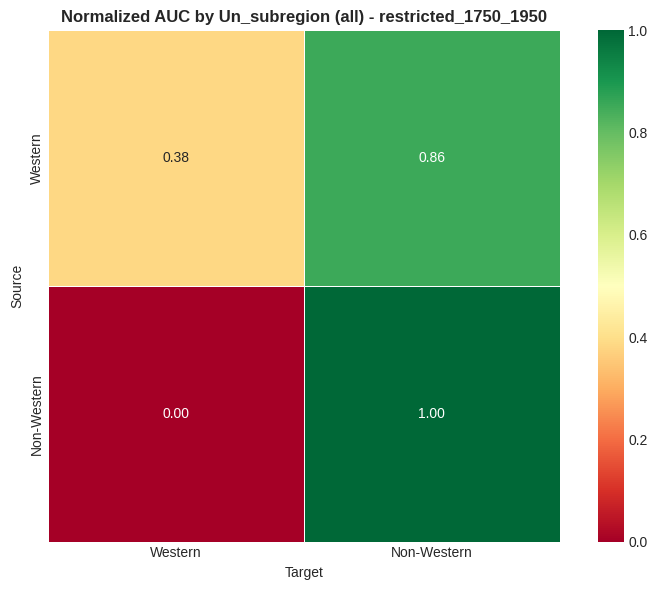

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_fullmatch_corrected_restricted_1750_1950_res50_min500_langs5_attrs3/retention_curves_restricted_1750_1950/retention_curves_all_bigperiod_birth.png


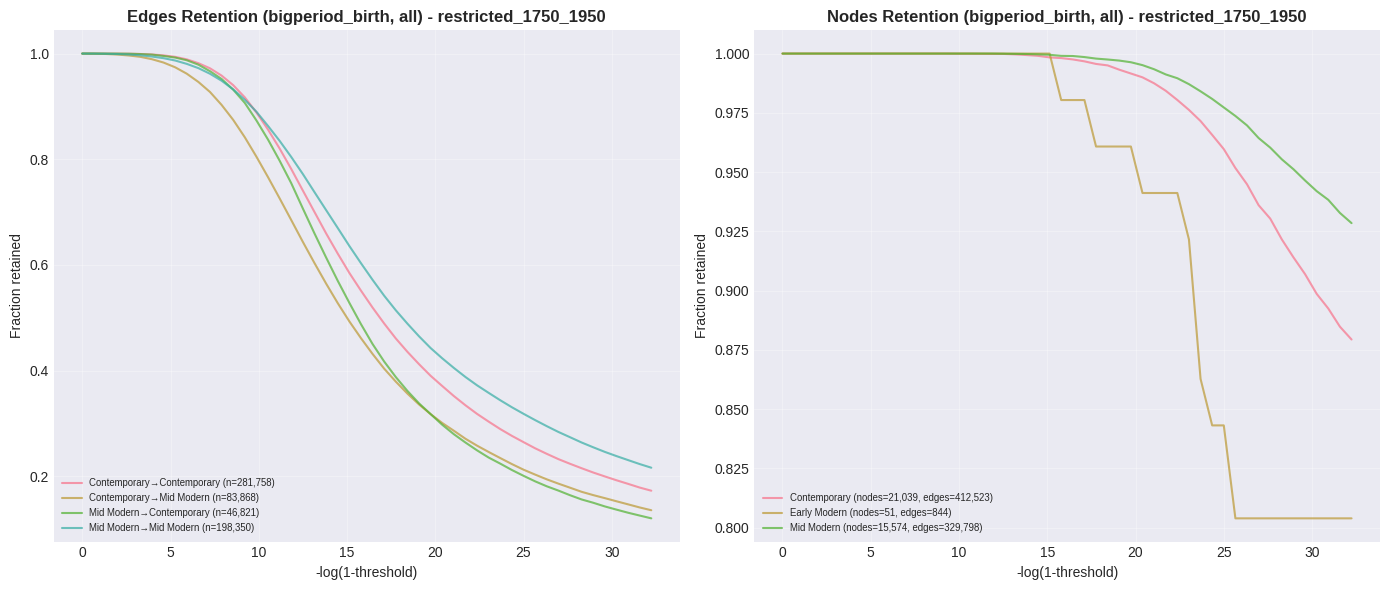

INFO: Saved plot: /home/vlr/Workspaces/WikipediaBiasProject/PyProject/data/out/plots/SpotlightWeightSource_0102_0505_fullmatch_corrected_restricted_1750_1950_res50_min500_langs5_attrs3/heatmaps_restricted_1750_1950/heatmap_all_bigperiod_birth.png


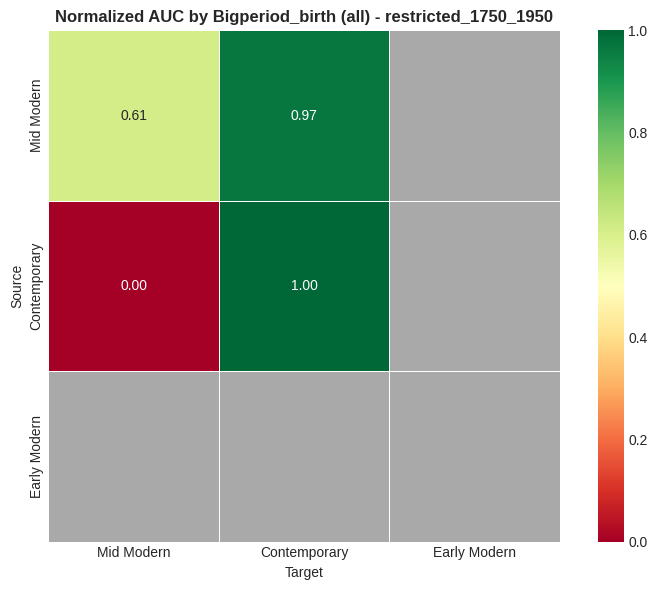

In [10]:
# Plot retention curves for both datasets
# Note: Plots are created and displayed, but only saved if they don't already exist

print("="*80)
print("FULL DATASET VISUALIZATIONS")
print("="*80)

# Check if plots directory has content (indicates existing plots)
full_plots_exist = (
    os.path.exists(OUTPUT_DIRS_FULL['retention_curves']) and 
    len(os.listdir(OUTPUT_DIRS_FULL['retention_curves'])) > 0
)

if full_plots_exist:
    print("Plots already exist. Creating displays but skipping save...")
    # Create plots but don't save by passing None as save_dir
    analysis.plot_retention_results(
        retention_full,
        languages=['en', 'all'],
        attributes=ATTRIBUTES,
        min_edges=MIN_EDGES,
        plot_type='both',
        figsize=(14, 6),
        save_dir=None
    )
else:
    print("Creating and saving plots...")
    analysis.plot_retention_results(
        retention_full,
        languages=['en', 'all'],
        attributes=ATTRIBUTES,
        min_edges=MIN_EDGES,
        plot_type='both',
        figsize=(14, 6),
        save_dir=OUTPUT_DIRS_FULL['base']
    )

print("\n" + "="*80)
print(f"TIME-RESTRICTED ({MIN_YEAR}-{MAX_YEAR}) VISUALIZATIONS")
print("="*80)

restricted_plots_exist = (
    os.path.exists(OUTPUT_DIRS_RESTRICTED['retention_curves']) and 
    len(os.listdir(OUTPUT_DIRS_RESTRICTED['retention_curves'])) > 0
)

if restricted_plots_exist:
    print("Plots already exist. Creating displays but skipping save...")
    analysis.plot_retention_results(
        retention_restricted,
        languages=['en', 'all'],
        attributes=ATTRIBUTES,
        min_edges=MIN_EDGES,
        plot_type='both',
        figsize=(14, 6),
        save_dir=None
    )
else:
    print("Creating and saving plots...")
    analysis.plot_retention_results(
        retention_restricted,
        languages=['en', 'all'],
        attributes=ATTRIBUTES,
        min_edges=MIN_EDGES,
        plot_type='both',
        figsize=(14, 6),
        save_dir=OUTPUT_DIRS_RESTRICTED['base']
    )

---
# Summary

**Analysis Complete!**

Results are organized by dataset name with parameter-inclusive directories, ensuring different configurations don't incorrectly reuse cached results.

**Directory Structure:**
```
data/out/plots/
├── {dataset}_{filter}_{params}/                 # e.g., SpotlightWeightSource_0102_0505_full_res50_min500_langs5_attrs3/
│   ├── auc_full/                                # AUC matrices for full dataset
│   ├── retention_data_full/                     # Retention curve CSV data (full)
│   │   ├── retention_curves_*.csv              # Edge retention (pairwise)
│   │   └── node_retention_*.csv                # Node retention (individual values)
│   ├── retention_curves_full/                   # Retention curve plots (full)
│   ├── heatmaps_full/                           # AUC heatmap plots (full)
│   └── cache_metadata.json                      # Cache validation metadata
└── {dataset}_restricted_{years}_{params}/       # e.g., SpotlightWeightSource_0102_0505_restricted_1750_1950_res50_min500_langs5_attrs3/
    ├── auc_restricted/                          # AUC matrices for restricted dataset
    ├── retention_data_restricted/               # Retention curve CSV data (restricted)
    │   ├── retention_curves_*.csv              # Edge retention (pairwise)
    │   └── node_retention_*.csv                # Node retention (individual values)
    ├── retention_curves_restricted/             # Retention curve plots (restricted)
    ├── heatmaps_restricted/                     # AUC heatmap plots (restricted)
    └── cache_metadata.json                      # Cache validation metadata
```

**Parameter-Aware Caching:**
- Directory names include analysis parameters: resolution, min_edges, language count, attribute count
- Different parameter combinations create separate cache directories
- `cache_metadata.json` stores full configuration for validation
- Results automatically loaded when parameters match
- Prevents incorrect cache reuse across different configurations

**Analyzed Attributes:**
- **gender**: Male vs Female representation
- **un_subregion**: Western vs Non-Western regions
- **bigperiod_birth**: Historical periods (Ancient, Post-Classical, Early Modern, Mid Modern, Contemporary)

**File Types:**
- **AUC CSVs**: Matrices showing Area Under Curve values for each attribute pair
- **Edge retention CSVs**: Complete x,y data for pairwise retention curves (e.g., Male→Female)
- **Node retention CSVs**: Complete x,y data for individual attribute value retention (e.g., Male, Female separately)
- **Retention curve PNGs**: Visual plots showing edge and node retention
- **Heatmap PNGs**: Color-coded matrices of normalized AUC values

**File Naming Convention:**
- Format: `{metric}_{language}_{attribute}.csv` (no timestamps)
- Language code: en, de, fr, it, es, all
- Attribute: gender, bigperiod_birth, un_subregion
- Examples: 
  - `auc_en_gender.csv` - AUC matrix
  - `retention_curves_all_un_subregion.csv` - Edge retention (pairwise)
  - `node_retention_en_gender.csv` - Node retention (individual values)